In [1]:
# Import Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
# Load the MNIST Dataset:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 102787543.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 24407756.16it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 43778668.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2774214.18it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Define the Generator and Discriminator Models:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input.view(-1, 28*28))


In [4]:
# Initialize the Models and Optimizers:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(D.parameters(), lr=0.0002)
optimizerG = optim.Adam(G.parameters(), lr=0.0002)


Epoch [1/50], d_loss: 0.043877072632312775, g_loss: 10.02901554107666
Epoch [2/50], d_loss: 2.037524703890085, g_loss: 3.2585561275482178
Epoch [3/50], d_loss: 0.23366529494524002, g_loss: 3.8050451278686523
Epoch [4/50], d_loss: 0.06702527403831482, g_loss: 6.601181983947754
Epoch [5/50], d_loss: 0.12258262559771538, g_loss: 4.810296535491943
Epoch [6/50], d_loss: 0.28363456577062607, g_loss: 6.0620503425598145
Epoch [7/50], d_loss: 0.30932631343603134, g_loss: 6.431196689605713
Epoch [8/50], d_loss: 0.2941173277795315, g_loss: 5.890320777893066
Epoch [9/50], d_loss: 0.0508943279273808, g_loss: 7.367209434509277
Epoch [10/50], d_loss: 0.22839615121483803, g_loss: 3.8986194133758545


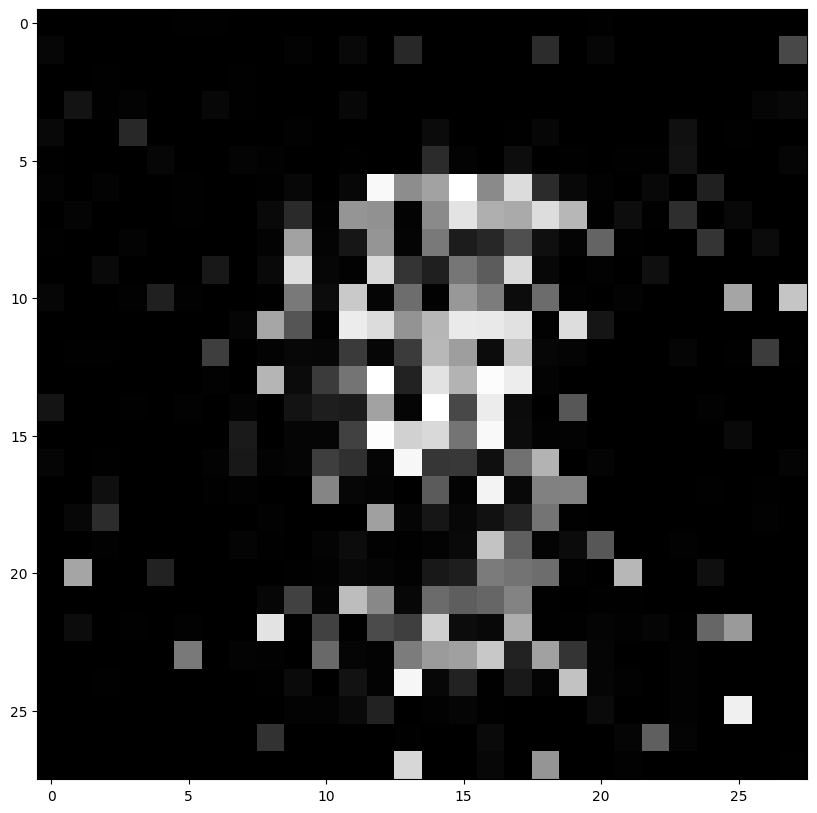

Epoch [11/50], d_loss: 0.1525411233305931, g_loss: 6.129650115966797
Epoch [12/50], d_loss: 0.09736601822078228, g_loss: 5.552150249481201
Epoch [13/50], d_loss: 0.26155897229909897, g_loss: 3.9116735458374023
Epoch [14/50], d_loss: 0.39765624701976776, g_loss: 4.691194534301758
Epoch [15/50], d_loss: 0.19444487988948822, g_loss: 4.877012252807617
Epoch [16/50], d_loss: 0.29203232377767563, g_loss: 4.0458083152771
Epoch [17/50], d_loss: 0.2928595244884491, g_loss: 3.556624412536621
Epoch [18/50], d_loss: 0.14745739102363586, g_loss: 4.047797679901123
Epoch [19/50], d_loss: 0.08674047514796257, g_loss: 4.460018157958984
Epoch [20/50], d_loss: 0.30902165174484253, g_loss: 3.000866174697876


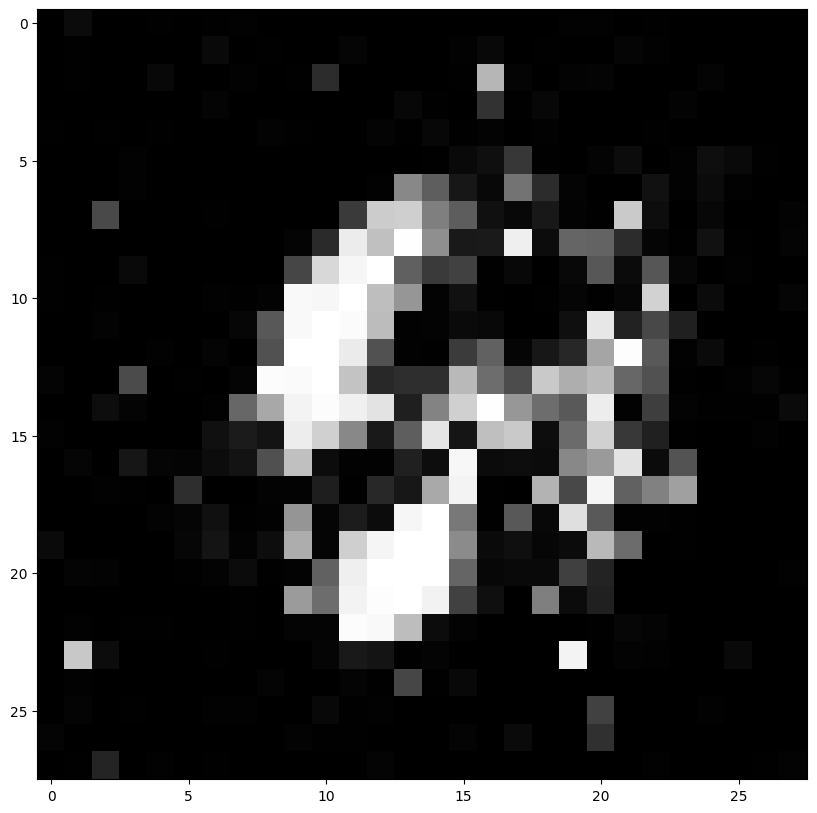

Epoch [21/50], d_loss: 0.2960898280143738, g_loss: 2.6585566997528076
Epoch [22/50], d_loss: 0.2886141389608383, g_loss: 4.430299758911133
Epoch [23/50], d_loss: 0.528971329331398, g_loss: 3.394972324371338
Epoch [24/50], d_loss: 0.4675191640853882, g_loss: 2.8398728370666504
Epoch [25/50], d_loss: 0.32337736338377, g_loss: 2.7699005603790283
Epoch [26/50], d_loss: 0.7072334289550781, g_loss: 3.1918158531188965
Epoch [27/50], d_loss: 0.39626652002334595, g_loss: 3.668518543243408
Epoch [28/50], d_loss: 0.5687686800956726, g_loss: 2.3025760650634766
Epoch [29/50], d_loss: 1.0398064851760864, g_loss: 1.9395852088928223
Epoch [30/50], d_loss: 0.7802533805370331, g_loss: 1.5117682218551636


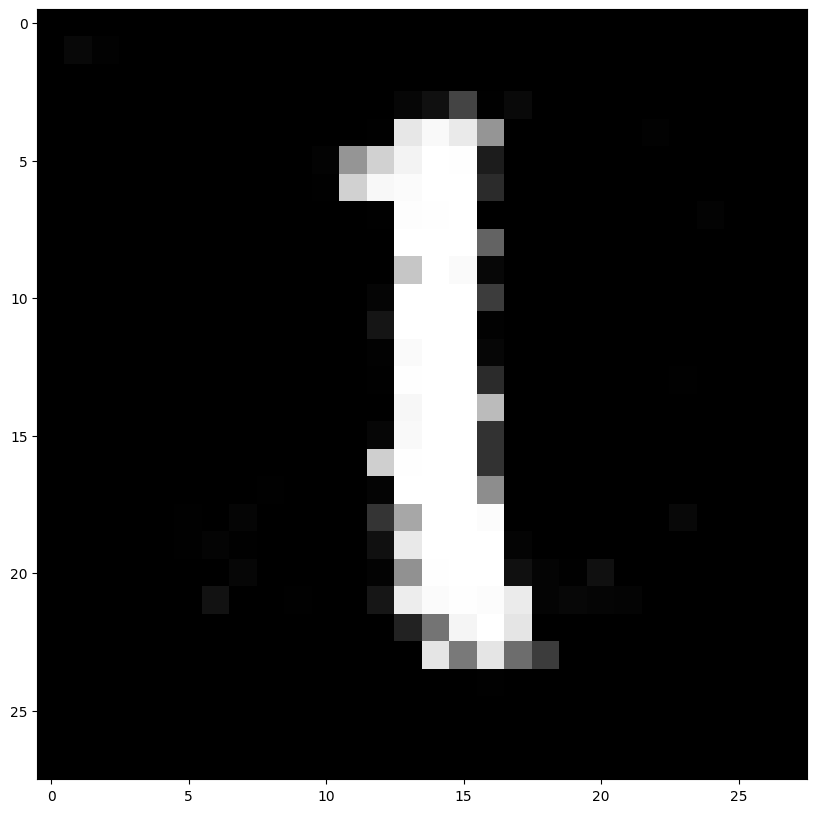

Epoch [31/50], d_loss: 0.5121686309576035, g_loss: 2.8597750663757324
Epoch [32/50], d_loss: 0.7036859393119812, g_loss: 2.8521103858947754
Epoch [33/50], d_loss: 0.9043352603912354, g_loss: 1.6763423681259155
Epoch [34/50], d_loss: 0.8668884038925171, g_loss: 1.4395852088928223
Epoch [35/50], d_loss: 0.6386968195438385, g_loss: 1.6818232536315918
Epoch [36/50], d_loss: 0.6314716637134552, g_loss: 1.8559458255767822
Epoch [37/50], d_loss: 0.7279911041259766, g_loss: 2.3027076721191406
Epoch [38/50], d_loss: 0.5776628106832504, g_loss: 2.6802940368652344
Epoch [39/50], d_loss: 1.0762564539909363, g_loss: 1.5588717460632324
Epoch [40/50], d_loss: 0.6117915362119675, g_loss: 1.7036715745925903


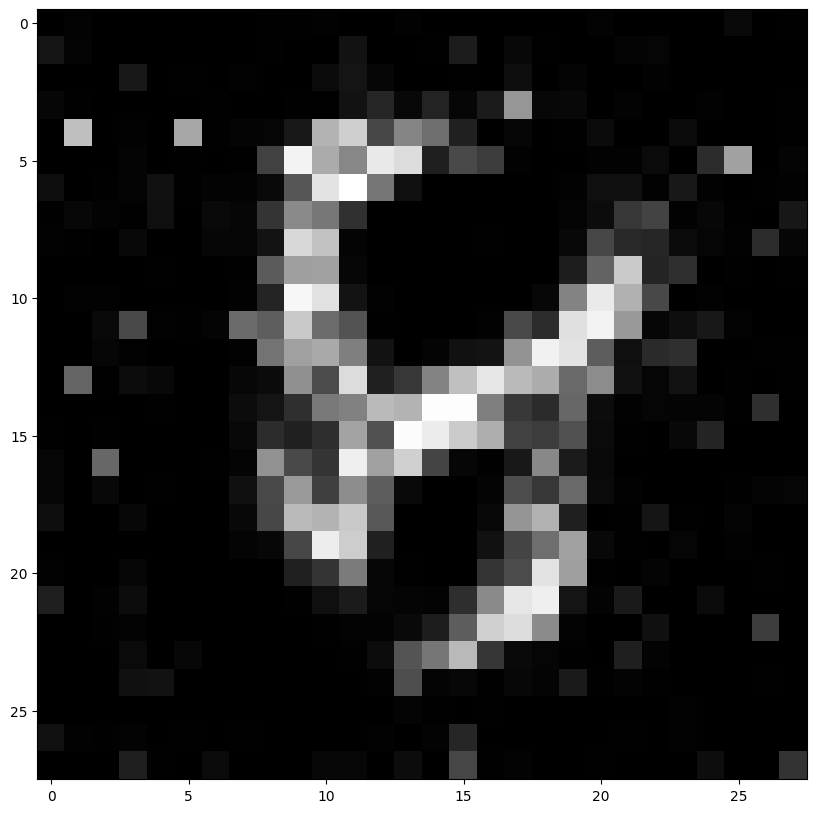

Epoch [41/50], d_loss: 0.9433589279651642, g_loss: 1.8241355419158936
Epoch [42/50], d_loss: 1.0189035534858704, g_loss: 1.9364761114120483
Epoch [43/50], d_loss: 0.8351522088050842, g_loss: 1.6411774158477783
Epoch [44/50], d_loss: 1.0791451930999756, g_loss: 1.0975226163864136
Epoch [45/50], d_loss: 0.9748075902462006, g_loss: 2.037346124649048
Epoch [46/50], d_loss: 0.9985125362873077, g_loss: 1.933472990989685
Epoch [47/50], d_loss: 0.6126572787761688, g_loss: 1.7832372188568115
Epoch [48/50], d_loss: 0.5961978137493134, g_loss: 1.6533935070037842
Epoch [49/50], d_loss: 0.8674614429473877, g_loss: 1.7117462158203125
Epoch [50/50], d_loss: 0.9163436889648438, g_loss: 1.616549015045166


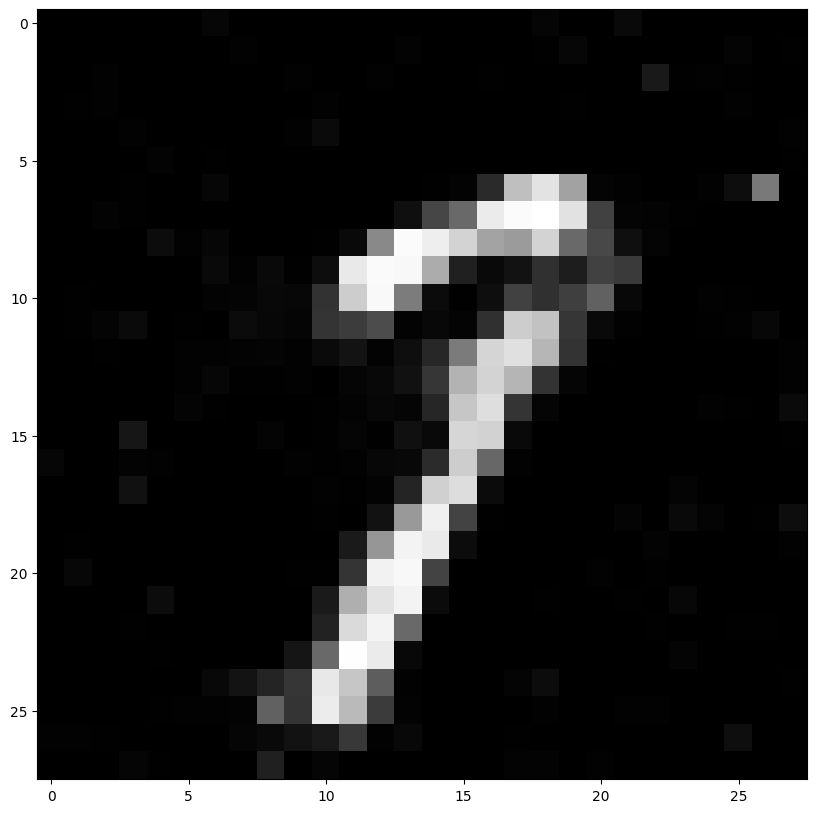

In [5]:
# Training Loop:

num_epochs = 50
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        D.zero_grad()
        labels = torch.ones(batch_size, 1).to(device)
        outputs = D(real_images)
        d_loss_real = criterion(outputs, labels)
        d_loss_real.backward()

        noise = torch.randn(batch_size, 100).to(device)
        fake_images = G(noise)
        labels = torch.zeros(batch_size, 1).to(device)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, labels)
        d_loss_fake.backward()

        optimizerD.step()

        # Train Generator
        G.zero_grad()
        labels = torch.ones(batch_size, 1).to(device)
        outputs = D(fake_images)
        g_loss = criterion(outputs, labels)
        g_loss.backward()

        optimizerG.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss_real.item() + d_loss_fake.item()}, g_loss: {g_loss.item()}')

    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            fake_images = G(noise).detach().cpu()
        plt.figure(figsize=(10,10))
        plt.imshow(fake_images[0].view(28,28), cmap='gray')
        plt.show()
